In [478]:
import sys
try:
    del sys.modules["spnhelp"]
except:
    pass
import spnhelp
try:
    del sys.modules["clg_revised"]
except:
    pass
from clg_revised import noise, Norm
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import likelihood
import scipy.stats as stats

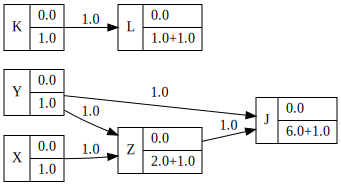

In [479]:

W = "X" @ noise
X = "X" @ noise
Y = "Y" @ noise
Z = "Z" @ (X + Y + noise)
J = "J" @ (Z + noise + Y)

K = "K" @ noise
L = "L" @ (K + noise)

Z & L

X.get_graph(True)

     Y    X    Z    J
Y  1.0  0.0  1.0  2.0
X  0.0  1.0  1.0  1.0
Z  1.0  1.0  3.0  4.0
J  2.0  1.0  4.0  7.0
X
     Z    J
Z  3.0  3.0
J  3.0  6.0


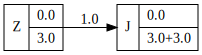

In [480]:
copy = X.deepcopy()
print(copy.get_Σ())
print(copy.name)

print(copy.castrate_roots().get_Σ())
copy.get_graph(True)

In [481]:
from itertools import product
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up

def pgm_to_spn(pgm : Norm, eps = 0.1, name_map = None):

    # name mapping:
    if name_map == None:
        name_map = {name : i for i, name in enumerate(pgm.get_scope(across_factors = True))}

    root_clusters = pgm.cluster_roots_by_dependence()

    
    global_factors = []

    for p in root_clusters:
        roots = list(p)

        if len(roots) == 1:
            print("[] making a gaussian leaf from", roots[0].name)
            global_factors.append(Gaussian(mean=roots[0].current_mean, stdev=roots[0].current_sd, scope = name_map[roots[0].name]))

        else:
            names = [n.name for n in roots]
            print("[] discretizing", names, "and generating cartesian product")
                        
            discs = [spnhelp.gauss_discretization_params(n.current_mean, n.current_sd, eps, spnhelp.split_until_at_most_eps_wide) for n in roots]
            
            summands = []
            sum_weights = []

            for vals in product(*discs): # for each possible assignment of the cells of the roots (cartesian product)
                sub_factor = []
                sum_weight = 1

                for i, v in enumerate(vals): # condition each root on the assignment
                    start, mid, end, weight = v
                    print("[] set", roots[i].name, "to", v[1])

                    roots[i].condition(mid, recompute_covariance_and_mean=False) # don't recompute the covariance and mean yet

                    sub_factor += Uniform(start=start, end=end, scope = name_map[roots[i].name]),
                    sum_weight *= weight
            
                roots[0].__recompute_params__() # recompute the covariance matrix and means here

                # now, get the pgm of the children.
                child = roots[0].castrate_roots()
                sub_factor += pgm_to_spn(child, eps = eps, name_map = name_map),

                summands += Product(sub_factor),
                sum_weights += sum_weight,
            
            S = Sum(summands, sum_weights)
            assign_ids(s)
            rebuild_scopes_bottom_up(s)

            global_factors.append(s)


    prod = Product(global_factors)
    return prod


pgm_to_spn(Z, eps = 2)

[] discretizing ['Y', 'X'] and generating cartesian product
[] set Y to 2.4678950486189444
[] set X to 2.4678950486189444
[] making a gaussian leaf from Z
[] set Y to 2.4678950486189444
[] set X to 0.8226316828729815


ValueError: Y ~ N(2.468, 0) is not in list